<a href="https://colab.research.google.com/github/martinloretzzz/vector-index-layer/blob/main/GPTVectorIndexOnOutEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans

In [22]:
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_text = "The quick brown fox"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

output = model.generate(
    input_ids,
    max_length=50,
    return_dict_in_generate=True,
    output_hidden_states=True,
    output_scores=True,
    output_logits=True
)

gen_tokens = output.sequences

gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The quick brown foxes are a great way to get a little bit of a kick out of your dog.

The quick brown foxes are a great way to get a little bit of a kick out of your dog. The quick brown fox


In [23]:
pos = 6

hidden = output.hidden_states
logits = output.logits

last_hidden = hidden[pos][-1].squeeze(0)
last_logits = logits[pos]

print(len(hidden), len(logits), len(hidden[pos]))
print(last_hidden.shape)
print(last_logits.shape)

46 46 13
torch.Size([1, 768])
torch.Size([1, 50257])


In [24]:
k = 50

topk_values, topk_indices = torch.topk(F.softmax(last_logits, dim=-1), k)
print(topk_values)
print(topk_indices)

tensor([[0.1144, 0.0270, 0.0261, 0.0240, 0.0220, 0.0218, 0.0163, 0.0146, 0.0145,
         0.0145, 0.0118, 0.0114, 0.0100, 0.0096, 0.0085, 0.0084, 0.0083, 0.0079,
         0.0079, 0.0077, 0.0077, 0.0070, 0.0069, 0.0066, 0.0065, 0.0059, 0.0056,
         0.0055, 0.0055, 0.0052, 0.0050, 0.0049, 0.0047, 0.0045, 0.0044, 0.0042,
         0.0041, 0.0041, 0.0041, 0.0040, 0.0040, 0.0038, 0.0038, 0.0038, 0.0037,
         0.0036, 0.0036, 0.0036, 0.0035, 0.0034]])
tensor([[  651,  1394,   905, 10400,   787,  4929,   923,   751,  8006,   766,
          1494,  1064,   423,  2193,  2222,  1011,  4545,  3613,  4729,  1037,
          1577,  2952,  1332,  4483,  3368,  3745,  1234,  1949,  1805,   467,
           779,  6654,   804,  4829,  4341,  2883, 19437,  5298,   886, 20528,
          2620,  2251,  1826,  7808,  8335,   711,  2245, 14947,  4512,  5911]])


In [25]:
out_emb_weight = model.transformer.wte.weight.detach().clone()
out_emb_weight.shape

torch.Size([50257, 768])

In [26]:
ncentroids = 2048
niter = 20

max_cluster_size = 32
nsearch = 32

In [27]:
# TODO: Inner product distance, normalize?
bkmeans = BisectingKMeans(n_clusters=ncentroids, random_state=42)
labels = torch.from_numpy(bkmeans.fit_predict(out_emb_weight))
centroids = torch.from_numpy(bkmeans.cluster_centers_).to(torch.float32)

centroids.shape

torch.Size([2048, 768])

In [28]:
# TODO run kmeans inside cluster to get more specific centroids
def limit_cluster_to_size(labels, centroids, max_cluster_size):
    n_labels, n_centorids = [], []
    new_clusters, new_clusters_count = {}, {}

    for l in labels.tolist():
        if l not in new_clusters or new_clusters_count[l] >= max_cluster_size:
            new_cluster = len(n_centorids)
            n_centorids.append(centroids[l])
            new_clusters[l] = new_cluster
            new_clusters_count[l] = 0

        n_labels.append(new_clusters[l])
        new_clusters_count[l] += 1

    return torch.tensor(n_labels, dtype=torch.int32), torch.stack(n_centorids)

n_labels, n_centorids = limit_cluster_to_size(labels, centroids, max_cluster_size)

In [29]:
print(torch.unique(n_labels, return_counts=True))
print(n_labels)
print(n_centorids.shape)

(tensor([   0,    1,    2,  ..., 2774, 2775, 2776], dtype=torch.int32), tensor([32, 30, 32,  ...,  1,  1,  1]))
tensor([   0,    0,    1,  ..., 2483, 2643, 2776], dtype=torch.int32)
torch.Size([2777, 768])


tensor([32, 32, 32,  ...,  1,  1,  1])


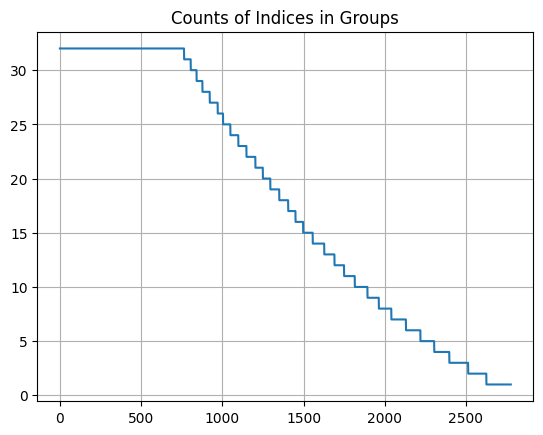

In [30]:
counts = torch.unique(n_labels, return_counts=True)[1]
counts = torch.sort(counts, descending=True)[0]
print(counts)
plt.plot(range(len(counts)), counts)
plt.grid()
plt.title("Counts of Indices in Groups")
plt.show()

In [31]:
def get_cluster_indices_padded(labels, max_cluster_size):
    cluster_count = len(torch.unique(labels))
    cluster_arange = torch.arange(len(labels))
    emb_from_centroid = torch.full((cluster_count, max_cluster_size), -1, dtype=torch.int32)

    for cluster_id in range(cluster_count):
        cluster_data = cluster_arange[labels == cluster_id]
        emb_from_centroid[cluster_id, :len(cluster_data)] = cluster_data
    return emb_from_centroid


emb_from_centroid = get_cluster_indices_padded(n_labels, max_cluster_size)
print(emb_from_centroid.shape)
emb_from_centroid

torch.Size([2777, 32])


tensor([[    0,     1,     6,  ...,   563,   590,   601],
        [    2,    93,   140,  ..., 37941,    -1,    -1],
        [    3,     4,     7,  ...,  1544,  1870,  1875],
        ...,
        [50180,    -1,    -1,  ...,    -1,    -1,    -1],
        [50252,    -1,    -1,  ...,    -1,    -1,    -1],
        [50256,    -1,    -1,  ...,    -1,    -1,    -1]], dtype=torch.int32)

In [32]:
cent = last_hidden.squeeze(0) @ n_centorids.T
print(cent.shape)

centers_values, center_indices = torch.topk(cent, k=nsearch)
centers_values, center_indices

torch.Size([2777])


(tensor([-132.2869, -132.2869, -132.2869, -132.7649, -132.7649, -132.9182,
         -133.4594, -133.4594, -133.5175, -133.6947, -133.8382, -134.0378,
         -134.0378, -134.0586, -134.1568, -134.1568, -134.4700, -134.4700,
         -134.6079, -134.9297, -135.1464, -135.2577, -135.3654, -135.4310,
         -135.4948, -135.4948, -135.5474, -135.5952, -135.6522, -135.6554,
         -135.8982, -135.8982]),
 tensor([  84,  951,  504,  140,  899,  320,  759,  159,  354, 1106,  123, 1052,
          118,  124,  155, 1082, 1259,  391,  280, 1384,   45,  311,  431,   55,
          866, 2038, 1298,  535,  134, 1932,    5,   93]))

In [33]:
# TODO: handle out of bound
search_idx = emb_from_centroid[center_indices].view(-1)
search_idx.shape

torch.Size([1024])

In [34]:
emb_idx = out_emb_weight[search_idx]
emb_idx.shape

torch.Size([1024, 768])

In [35]:
logits_idx = last_hidden.squeeze(0) @ emb_idx.T
logits_idx.shape

torch.Size([1024])

In [36]:
idx_values, idx_indices_raw = torch.topk(logits_idx, k)
idx_indices = search_idx[idx_indices_raw]
print(idx_values, idx_indices_raw)
print(idx_indices)

tensor([-127.7823, -129.2252, -129.2598, -129.3449, -129.4318, -129.4405,
        -129.7332, -129.8380, -129.8471, -130.0565, -130.0877, -130.2641,
        -130.3804, -130.3933, -130.4101, -130.4501, -130.4596, -130.4787,
        -130.4790, -130.5951, -130.7422, -130.8116, -130.8119, -130.8795,
        -130.9045, -130.9355, -130.9832, -131.0176, -131.0489, -131.0860,
        -131.1094, -131.1153, -131.1362, -131.1743, -131.1854, -131.1877,
        -131.2218, -131.2353, -131.2375, -131.2424, -131.2632, -131.2851,
        -131.2899, -131.2996, -131.3229, -131.3530, -131.4123, -131.4164,
        -131.4252, -131.4872]) tensor([  1,  13, 225, 273,   4, 124,  97,   2, 201, 102,   8,  22,  24,   5,
        260,  71, 550,   6,  15,  99, 114,  20,  18,   0,   3, 129,  96, 472,
        340, 331, 344, 224,  27,  25,  19, 770,  35, 385, 237, 834, 162,  93,
         80, 101, 107, 457,  82, 100, 513,  67])
tensor([  651,  1394,   905, 10400,   787,  4929,   923,   751,  8006,  1494,
         1064,  

In [37]:
def get_common(indices, ref_indices):
    return [i for i in ref_indices.tolist()[0:j] if i in indices.tolist()]

exp_logits = torch.exp(last_logits.to(torch.float64).squeeze(0))

for j in [10, 20, 50]:
    common_indices = torch.tensor(get_common(idx_indices.squeeze(0), topk_indices.squeeze(0)))
    exp_logits_all = exp_logits[idx_indices.squeeze(0)[0:j]]

    exp_logits_common = exp_logits[common_indices]
    logits_percentage = exp_logits_common.sum() / exp_logits_all.sum()

    print(f"{len(common_indices)}/{j} ({len(common_indices)/j:0.2f}), logits: {logits_percentage:0.4f}")

9/10 (0.90), logits: 0.9598
18/20 (0.90), logits: 0.9613
42/50 (0.84), logits: 0.9492


In [45]:
exp_logits_common / exp_logits_all.sum()

tensor([0.2302, 0.0544, 0.0525, 0.0483, 0.0442, 0.0439, 0.0327, 0.0295, 0.0292,
        0.0237, 0.0230, 0.0192, 0.0171, 0.0169, 0.0166, 0.0160, 0.0158, 0.0155,
        0.0155, 0.0138, 0.0119, 0.0111, 0.0111, 0.0104, 0.0101, 0.0098, 0.0094,
        0.0091, 0.0088, 0.0085, 0.0083, 0.0082, 0.0080, 0.0077, 0.0077, 0.0076,
        0.0074, 0.0073, 0.0073, 0.0072, 0.0071, 0.0069], dtype=torch.float64)